# Copying kaggle.json file to ~/.kaggle folder 

In [1]:
# Create a folder named .kaggle
!mkdir -p ~/.kaggle/

# Copy the kaggle.json API token file to this directory
!cp kaggle.json ~/.kaggle/

# Change permission so that only you can read-write
!chmod 600 /root/.kaggle/kaggle.json

# Downloading the dataset from kaggle

In [2]:
# Installing the kaggle api for downloading dataset
!pip install -q kaggle

# Downloading the dataset
!kaggle datasets download -d puneet6060/intel-image-classification

 97% 337M/346M [00:06<00:00, 48.9MB/s]
100% 346M/346M [00:07<00:00, 51.7MB/s]


# Importing the libraries

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import plot_model
import zipfile
from datetime import datetime
import os

# Extract the dataset from the zip file

In [4]:
zf = zipfile.ZipFile("intel-image-classification.zip")
zf.extractall("NatureDataset/")

# Specify path and other global parameters

In [5]:
# Parameters
train_path = "NatureDataset/seg_train/seg_train"
test_path = "NatureDataset/seg_test/seg_test"
pred_path = "NatureDataset/seg_pred/"
batch_size = 64
image_dim = (64,64)
shape = list(image_dim) + [3]

# Create the training and test data generators

In [6]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    zoom_range=0.1,
                    brightness_range=(0.8,1.0)
                )

train_generator = train_datagen.flow_from_directory(train_path, target_size=image_dim,batch_size=batch_size)

Found 14034 images belonging to 6 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_path, target_size=image_dim)

Found 3000 images belonging to 6 classes.


# Defining utility functions for displaying the images

In [8]:
# Utility functions
def create_label_dict(class_indices):
    return dict([(v, k) for k, v in class_indices.items()])

def get_label_from_encodings(encodings, label_dict):
    indices = np.argmax(encodings, axis=1)
    labels = np.array(list(map(lambda x: label_dict[x], indices)))
    return labels

def show_images(images, predictions, ground_truth = None, n=32):
    plt.figure(figsize=(20, 10))
    n_rows = int(np.ceil(n/8))
    for i in range(0, n):
        plt.subplot(n_rows, 8, i+1)
        plt.imshow(images[i])
        plt.axis(False)
        title = plt.title(predictions[i])
        if ground_truth is not None:
            if predictions[i] == ground_truth[i]:
                title.set_color("green")
            else:
                title.set_color("red")

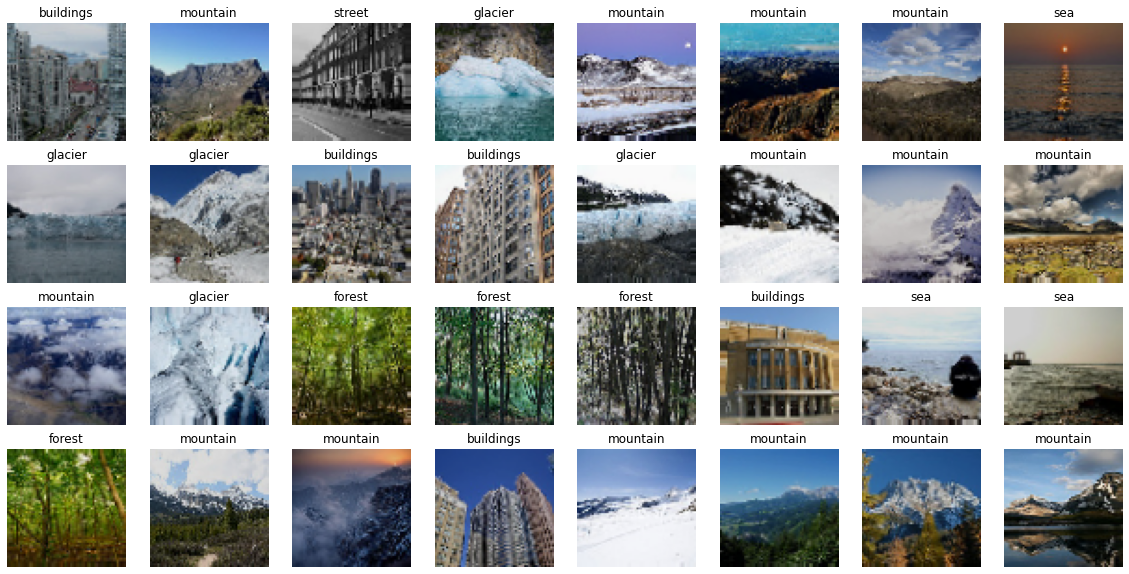

In [9]:
# Show some sample images
image_batch, targets = train_generator.next()
label_dict = create_label_dict(train_generator.class_indices)
labels = get_label_from_encodings(targets, label_dict)
show_images(image_batch, labels)

# Building the model

In [10]:
# Function to build and return the model 
def create_model():
    inputs = tf.keras.layers.Input(shape=(shape))

    x = tf.keras.layers.Conv2D(32, (3,3), activation="relu")(inputs)
    block1_out = tf.keras.layers.MaxPooling2D((2,2))(x)

    
    x = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same",kernel_regularizer=tf.keras.regularizers.L2(0.008))(block1_out)
    x = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    block2_out = tf.keras.layers.concatenate([x, block1_out])
    
    x = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.L2(0.008))(block2_out)
    x = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    block3_out = tf.keras.layers.concatenate([x, block2_out])

    x = tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.L2(0.008))(block3_out)
    x = tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    block4_out = tf.keras.layers.concatenate([x, block3_out]) 


    x = tf.keras.layers.GlobalAveragePooling2D()(block4_out)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(6, activation="softmax")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=x)
    return model

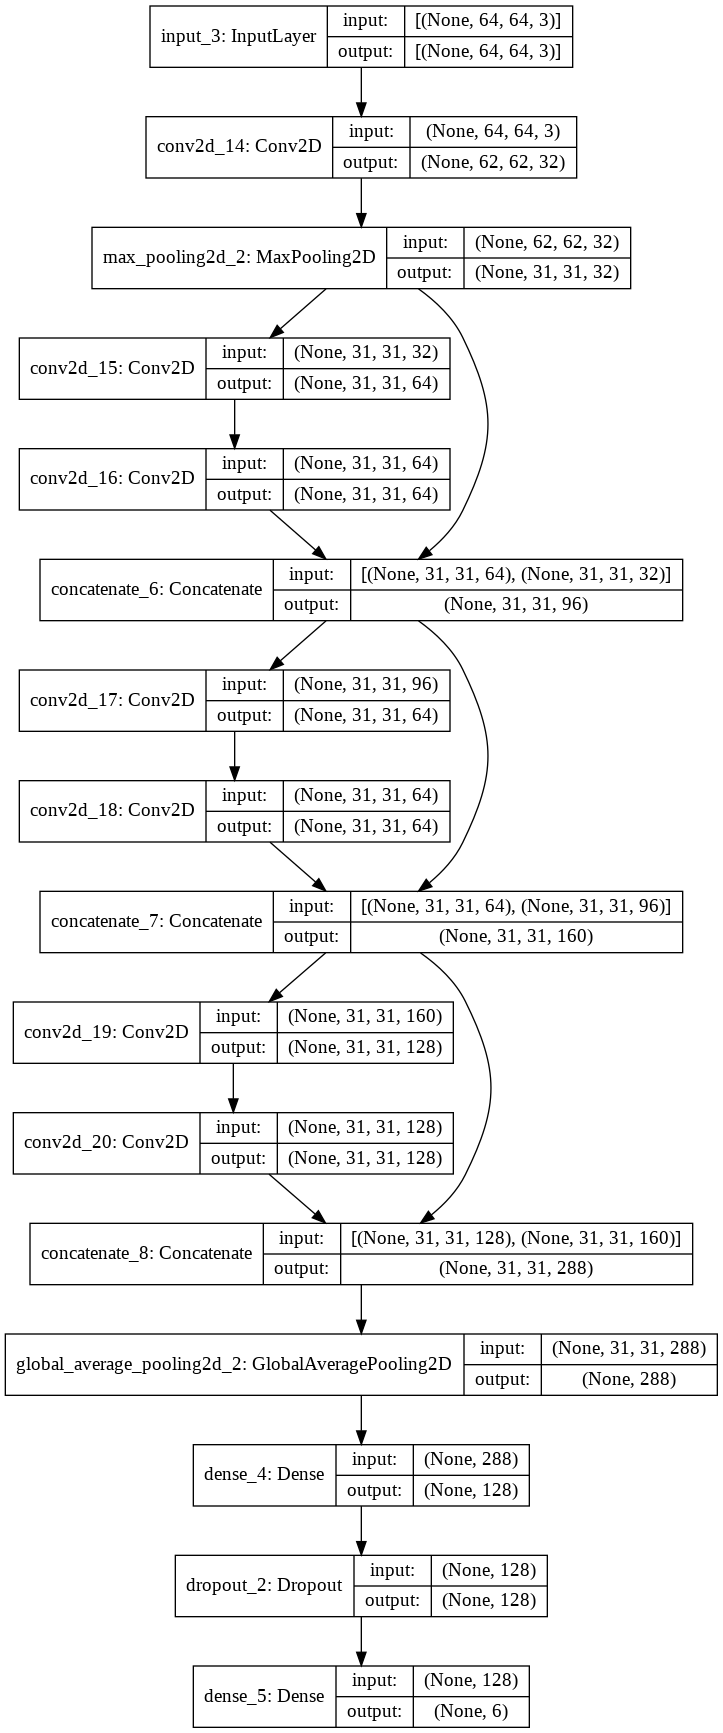

In [26]:
# Instantiate the model
model = create_model()
plot_model(model, show_shapes=True)

# Determining the optimum learning rate using a Learning Rate Scheduler

(1e-07, 1.0)

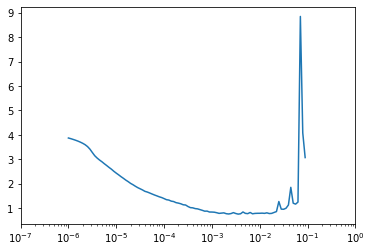

In [12]:
# Determine the optimum learning rate
INIT_LR = 1e-6
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: INIT_LR * 10**(epoch/20))
lr_model = create_model()
lr_model.compile(optimizer=tf.keras.optimizers.Adam(INIT_LR),loss='categorical_crossentropy',metrics=['acc'])
lr_history = lr_model.fit(
    train_generator,
    batch_size=batch_size,
    validation_data = test_generator,
    epochs=100,
    callbacks = [lr_scheduler],
    verbose=0
)
plt.semilogx(lr_history.history['lr'], lr_history.history['loss'])
plt.xlim(1e-6, 1e0)

# Defining callbacks for training

In [19]:
# Custom Callback to detect overfitting.
# Also, stops training after reaching a target validation accuracy
class DetectOverfitting(tf.keras.callbacks.Callback):
    def __init__(self, threshold, target_acc):
        self.threshold = threshold
        self.target_acc = target_acc
    def on_epoch_end(self, epoch, logs = None):
        if logs["val_loss"]/logs["loss"] >= self.threshold or logs["val_acc"]>=self.target_acc:
            print(f"Stopping training.")
            self.model.stop_training = True

In [23]:
# Model Checkpoint callback for saving the best models
checkpoint_path = "checkpoints/model{val_acc}.h5"
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor = "val_acc",
    save_weights_only=True,
    save_best_only = True,
    mode = "max"
)

# Instantiate the DetectOverfitting callback
detect_overfitting = DetectOverfitting(threshold=1.3, target_acc=0.85)

# Compiling and training the model

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss='categorical_crossentropy',metrics=['acc'])
train_loss = []
train_acc = []
val_loss = []
val_acc = []

In [28]:
history = model.fit(
    train_generator,
    batch_size=batch_size,
    validation_data = test_generator,
    epochs=100,
    initial_epoch=0,
    callbacks=[modelCheckpoint, detect_overfitting]
)

Epoch 1/100
220/220 [==============================] - 46s 205ms/step - loss: 1.6085 - acc: 0.4076 - val_loss: 1.2011 - val_acc: 0.4950
Epoch 2/100
220/220 [==============================] - 45s 204ms/step - loss: 1.2204 - acc: 0.5006 - val_loss: 1.1916 - val_acc: 0.5050
Epoch 3/100
220/220 [==============================] - 45s 203ms/step - loss: 1.1514 - acc: 0.5218 - val_loss: 1.0808 - val_acc: 0.5507
Epoch 4/100
220/220 [==============================] - 44s 202ms/step - loss: 1.0850 - acc: 0.5556 - val_loss: 1.0492 - val_acc: 0.5753
Epoch 5/100
220/220 [==============================] - 44s 199ms/step - loss: 1.0405 - acc: 0.5998 - val_loss: 1.2136 - val_acc: 0.5310
Epoch 6/100
220/220 [==============================] - 44s 201ms/step - loss: 0.9915 - acc: 0.6255 - val_loss: 0.9727 - val_acc: 0.6290
Epoch 7/100
220/220 [==============================] - 45s 205ms/step - loss: 0.9352 - acc: 0.6618 - val_loss: 1.0108 - val_acc: 0.6417
Epoch 8/100
220/220 [===========================

# Plotting the training and validation metrics 

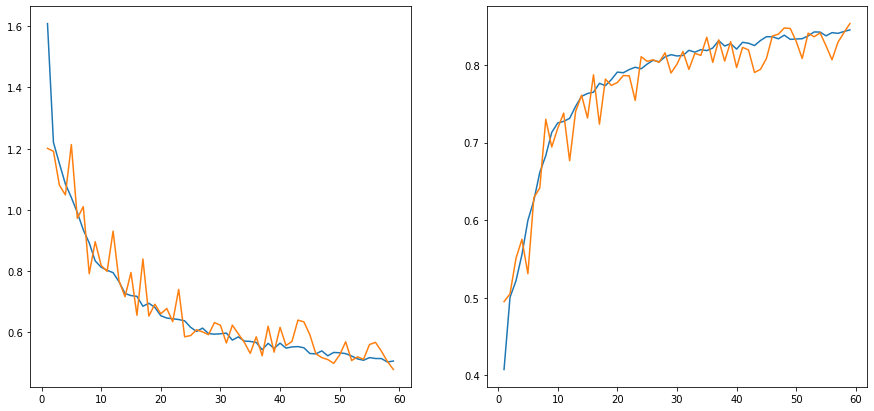

In [29]:
train_loss += history.history['loss']
train_acc += history.history['acc']
val_loss += history.history['val_loss']
val_acc += history.history['val_acc']
epochs = list(range(1, len(train_loss)+1))

plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss)
plt.plot(epochs, val_loss)
plt.subplot(1,2,2)
plt.plot(epochs, train_acc)
plt.plot(epochs, val_acc)
plt.show()

In [35]:
# Save the model, its architecture and its weights
now = datetime.now()
current_time = now.strftime("%d:%m_%H:%M")
dirpath = "models/model_{}".format(current_time)
try:
    os.mkdir(dirpath)
except:
    pass
model.save(dirpath + "/model_{}.h5".format(current_time))
plot_model(model, dirpath + "/architecture.png", show_shapes=True, show_layer_names=True)
model.save_weights(dirpath + "/model_weights_{}.h5".format(current_time))

# Running the trained model on the test set 

In [30]:
# Evaluate on test set
model.evaluate(test_generator)

94/94 [==============================] - 3s 33ms/step - loss: 0.4790 - acc: 0.8533


[0.4790152311325073, 0.8533333539962769]

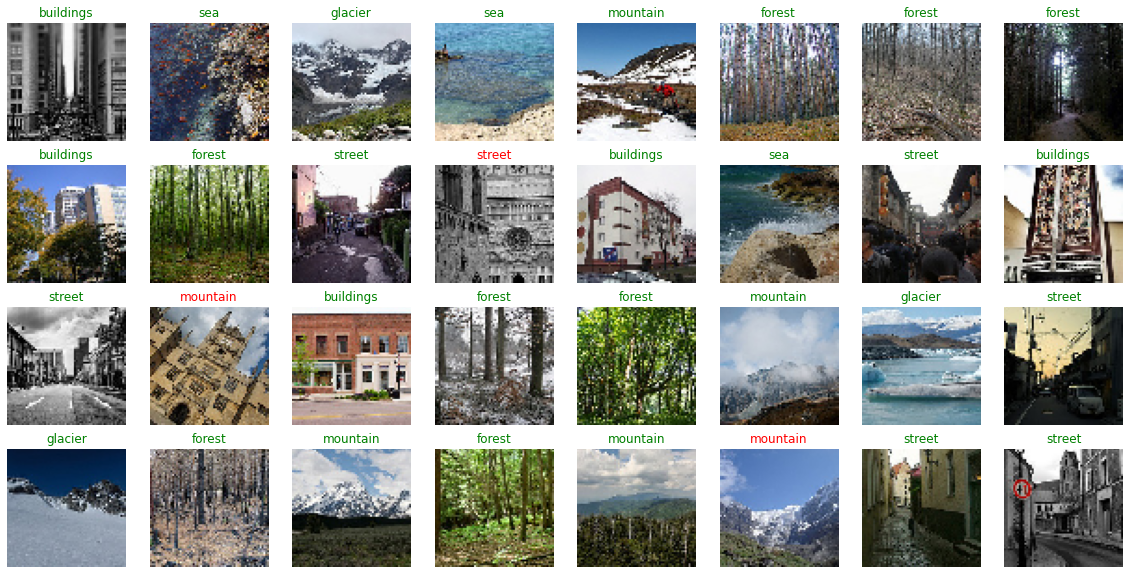

In [31]:
# Visualize predictions from test set
image_batch, ground_truth = test_generator.next()
predictions = model.predict(test_generator)
ground_truth = get_label_from_encodings(ground_truth, label_dict)
predictions = get_label_from_encodings(predictions, label_dict)
show_images(image_batch, predictions, ground_truth)

# Making predictions on the pred set

In [33]:
# Create the prediction dataset generator
pred_datagen = ImageDataGenerator(rescale=1.0/255.0)
pred_generator = pred_datagen.flow_from_directory(pred_path, class_mode=None)

Found 7301 images belonging to 1 classes.


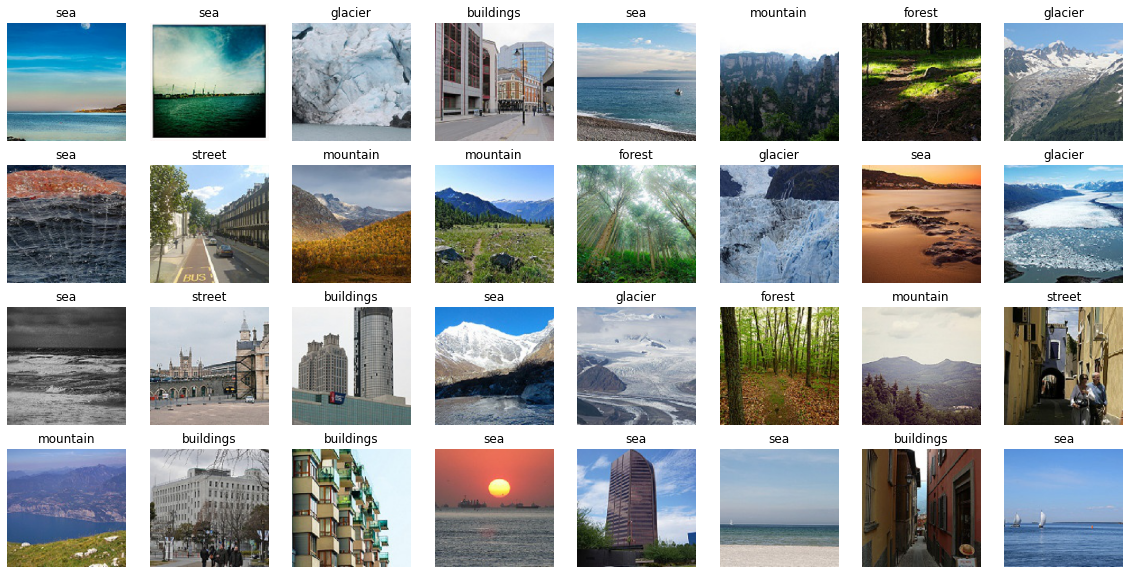

In [34]:
# Visualize predictions from the pred set
image_batch_pred = pred_generator.next()
predictions_pred = model.predict(pred_generator)
predictions_pred = get_label_from_encodings(predictions_pred, label_dict)
show_images(image_batch_pred, predictions_pred)

In [ ]:
tf.keras.backend.clear_session()